In [1]:
! pip install gpyopt

    100% |████████████████████████████████| 61kB 3.7MB/s 
    100% |████████████████████████████████| 880kB 7.0MB/s 
    100% |████████████████████████████████| 71kB 10.1MB/s 
  Running setup.py bdist_wheel for gpyopt ... done
  Stored in directory: /root/.cache/pip/wheels/33/1d/87/dc02440831ba986b1547dd11a7dcd44e893b0527083066d869
  Running setup.py bdist_wheel for GPy ... done
  Stored in directory: /root/.cache/pip/wheels/97/82/1d/32a361e1ff2b4d9129a60343831dd99cdc74440e2db1c55264
  Running setup.py bdist_wheel for paramz ... done
  Stored in directory: /root/.cache/pip/wheels/a9/fc/74/3bbd263c43ed98d67343df24cebf0a0ee34afee40d769fda9c
Successfully built gpyopt GPy paramz
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 2.2.3 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.2.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.1.0 which is incompatible.
You are using p

In [2]:
########## 0 - Importing relevant libraries
import h5py
import sklearn
import matplotlib.pyplot as plt
import GPyOpt
import GPy

from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

import numpy as np
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Conv1D, Flatten, MaxPooling1D 
from keras import initializers
from keras import regularizers , optimizers
import scipy.io as sio

Using TensorFlow backend.


In [3]:
###############  1 - LOADING PORTION OF TRAINING AND DEV SET ############### 
## loading training set
train = h5py.File('/floyd/input/echogrampreprocessed/EchogramPreprocessed.mat','r')
label_train = np.array(train['label'])
X_train = np.array(train['EchogramWithBottom'])

In [4]:
## 1.2 - Resizing the training set, 
# in fact there is too many pings ~2.3 million it won't fit into memory
np.random.seed(7)
m,_ = X_train.shape
index = np.random.choice(m,500000,replace=False)
label_train = label_train[index,:]
X_train = X_train[index,:]

In [5]:
## 1.3 - Preprocessing step
# Replacing Nan with -200
X_train = np.add(np.nan_to_num(X_train),np.isnan(X_train) * -200)

In [6]:
## 1.4 - loading development set
dev = sio.loadmat('/floyd/input/devset/EchogramDev.mat')
X_dev = np.array(dev['Echogram'])
label_dev = np.array(dev['label'])

# Replacing Nan with -200
X_dev = np.add(np.nan_to_num(X_dev), np.isnan(X_dev) * -200)

In [8]:
############### 2 - RESHAPE THE TWO DATASETS  ############### 
##  Reshaping the data to feed the convolutional neural network
m_train,n = X_train.shape
m_dev,n = X_dev.shape
X_train = X_train.reshape(m_train,n,1)
X_dev = X_dev.reshape(m_dev,n,1)

Y_train = to_categorical(label_train)
Y_train = Y_train[:,1:]

Y_dev =  to_categorical(label_dev)
Y_dev =  Y_dev[:,1:]

In [15]:
############### 3 - BAYESIAN OPTIMIZATION  ############### 
# 3.1 - We start by evaluating a model that we found quite effective 
# the hyperparmeters tuning was done by hand
def variable_CNN(dropout1, kernel_1, kernel_2, kernel_3, no_unit1, no_unit2, no_unit3):
    # create model
    model = Sequential()
    ## 1st Conv Layer
    model.add(Conv1D(input_shape=[2550,1], filters=1, kernel_size=kernel_1, strides=2, activation='selu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=kernel_1, strides=1, padding='valid'))  
    ## 2nd Conv Layer
    model.add(Conv1D(filters=1, kernel_size=kernel_2, strides=1, activation='selu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=kernel_2, strides=1, padding='valid')) 
    ## 3rd Conv Layer
    model.add(Conv1D(filters=1, kernel_size=kernel_3, strides=1, activation='selu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=kernel_3, strides=1, padding='valid')) 
    model.add(Flatten())
    ## Fully Connected Layers
    model.add(Dropout(dropout1))
    model.add(Dense(no_unit1,kernel_initializer="normal", bias_initializer='zeros', activation='selu',kernel_constraint=maxnorm(3)))
    model.add(Dense(no_unit2,kernel_initializer="normal", bias_initializer='zeros', activation='selu',kernel_constraint=maxnorm(3)))
    model.add(Dense(no_unit3,kernel_initializer="normal", bias_initializer='zeros', activation='selu',kernel_constraint=maxnorm(3)))
    model.add(Dense(2, kernel_initializer="normal", bias_initializer='zeros', activation='sigmoid')) 
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model    


vnn = variable_CNN(0.6, 43,  22,  43, 325, 293,  74)
vnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_64 (Conv1D)           (None, 1254, 1)           44        
_________________________________________________________________
batch_normalization_64 (Batc (None, 1254, 1)           4         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 1212, 1)           0         
_________________________________________________________________
conv1d_65 (Conv1D)           (None, 1191, 1)           23        
_________________________________________________________________
batch_normalization_65 (Batc (None, 1191, 1)           4         
_________________________________________________________________
max_pooling1d_65 (MaxPooling (None, 1170, 1)           0         
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 1128, 1)           44        
__________

In [16]:
# 3.2 We evaluate the loss with this model to get a standard value.
history = vnn.fit(X_train, Y_train, epochs = 1, validation_data=(X_dev,Y_dev), batch_size = 8192, shuffle=True)
baseline_score = history.history["val_loss"][0]
baseline_score

Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 34s 67us/step - loss: 0.2072 - acc: 0.8991 - val_loss: 0.2223 - val_acc: 0.8435


0.22234930213928222

In [17]:
# 3.3 Optimization procedure
# We will make the hyperparameters to vary within the bounds that we define
# down below.
def variable_CNN(kernel_1, kernel_2, kernel_3, no_unit1, no_unit2, no_unit3, dropout1, dropout2, dropout3):
    # create model
    model = Sequential()
    ## 1st Conv Layer
    model.add(Conv1D(input_shape=[2550,1], filters=1, kernel_size=kernel_1, strides=2, activation='selu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=kernel_1, strides=1, padding='valid'))  
    ## 2nd Conv Layer
    model.add(Conv1D(filters=1, kernel_size=kernel_2, strides=1, activation='selu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=kernel_2, strides=1, padding='valid')) 
    ## 3rd Conv Layer
    model.add(Conv1D(filters=1, kernel_size=kernel_3, strides=1, activation='selu'))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling1D(pool_size=kernel_3, strides=1, padding='valid')) 
    model.add(Flatten())
    model.add(Dropout(dropout1))
    model.add(Dense(no_unit1,kernel_initializer="normal", bias_initializer='zeros', activation='selu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout2))
    model.add(Dense(no_unit2,kernel_initializer="normal", bias_initializer='zeros', activation='selu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(dropout3))
    model.add(Dense(no_unit3,kernel_initializer="normal", bias_initializer='zeros', activation='selu', kernel_constraint=maxnorm(3)))
    model.add(Dense(2, kernel_initializer="normal", bias_initializer='zeros', activation='sigmoid')) 
    # Custom optimizer
	# Compile model
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model    

# Function to optimize
# We aim to maximize this function with respect to the parameters
# learning_rate and no_unit_layer1
def f(x):
    kernel_1 = int(x[:,0])
    kernel_2 = int(x[:,1])
    kernel_3 = int(x[:,2])
    no_unit1 = int(x[:,3])
    no_unit2 = int(x[:,4])
    no_unit3 = int(x[:,5])
    dropout1 = int(x[:,6])
    dropout2 = int(x[:,7])
    dropout3 = int(x[:,8])
    vnn = variable_CNN(kernel_1 ,  kernel_2,  kernel_3 , no_unit1, no_unit2, no_unit3,dropout1, dropout2, dropout3)
    history = vnn.fit(X_train, Y_train, epochs = 1, validation_data=(X_dev,Y_dev), batch_size = 8192, shuffle=True)
    score = history.history["val_loss"][0]
    return score

bounds = [
            {'name': 'kernel_1', 'type': 'discrete', 'domain': np.arange(5,60)},        
            {'name': 'kernel_2', 'type': 'discrete', 'domain': np.arange(5,60)},
            {'name': 'kernel_3', 'type': 'discrete', 'domain': np.arange(5,60)},        
            {'name': 'no_unit1', 'type': 'discrete', 'domain': np.arange(5,600)},
            {'name': 'no_unit2', 'type': 'discrete', 'domain': np.arange(5,320)},    
            {'name': 'no_unit3', 'type': 'discrete', 'domain': np.arange(5,160)}, 
            {'name': 'dropout1', 'type': 'discrete', 'domain': np.arange(0.0,1.0,0.1)}, 
            {'name': 'dropout2', 'type': 'discrete', 'domain': np.arange(0.0,1.0,0.1)}, 
            {'name': 'dropout3', 'type': 'discrete', 'domain': np.arange(0.0,1.0,0.1)},     
         ]

In [18]:
# The bayesion procedure will at each turn evaluate a set of hyperparameters.
optimizer = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds,
                                                        acquisition_type = 'EI',
                                                        acquisition_par = 0.1,                                                    
                                                        model_type='GP')

Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 33s 65us/step - loss: 0.2002 - acc: 0.8991 - val_loss: 0.2152 - val_acc: 0.7585
Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 32s 64us/step - loss: 0.2749 - acc: 0.8824 - val_loss: 0.2734 - val_acc: 0.7570
Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 30s 61us/step - loss: 0.2044 - acc: 0.8998 - val_loss: 0.0945 - val_acc: 0.9457
Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 30s 60us/step - loss: 0.2108 - acc: 0.8994 - val_loss: 0.3903 - val_acc: 0.7570
Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 37s 75us/step - loss: 0.2192 - acc: 0.8986 - val_loss: 0.3255 - val_acc: 0.7571


In [19]:
%%time
optimizer.run_optimization(max_iter=15, eps=-1)

Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 34s 69us/step - loss: 0.1983 - acc: 0.8989 - val_loss: 0.2444 - val_acc: 0.8160
Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 33s 66us/step - loss: 0.2553 - acc: 0.9003 - val_loss: 0.2858 - val_acc: 0.7570
Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 38s 76us/step - loss: 0.2044 - acc: 0.9028 - val_loss: 0.2591 - val_acc: 0.7570
Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 33s 66us/step - loss: 0.2240 - acc: 0.8985 - val_loss: 0.2784 - val_acc: 0.7570
Train on 500000 samples, validate on 100000 samples
Epoch 1/1
500000/500000 [==============================] - 35s 69us/step - loss: 0.2055 - acc: 0.8979 - val_loss: 0.3100 - val_acc: 0.7570
Train on 500000 samples, validate on 100000 s

kernel1, kernel2, kernel3: [56. 54. 13.]
no_unit1, no_unit2, no_unit3: [303. 202.  81.]
dropout1, dropout2, dropout3: [0.5 0.6 0. ]


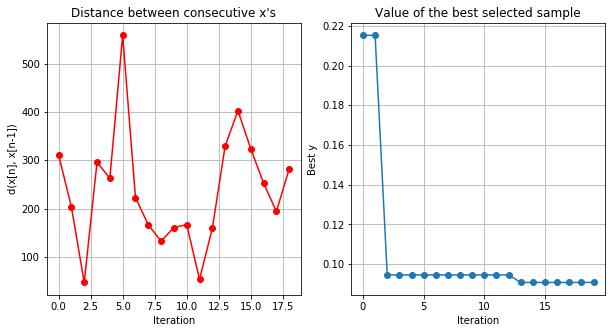

performance_boost: % 145.12159984888183


In [20]:
# Output the hyperparameters with the lowest loss
best_hyperparameters = optimizer.X[np.argmin(optimizer.Y)]
print('kernel1, kernel2, kernel3:', best_hyperparameters[0:3])
print('no_unit1, no_unit2, no_unit3:', best_hyperparameters[3:6])
print('dropout1, dropout2, dropout3:',best_hyperparameters[6:9])

# Plot the optimizer convergence
# two graphs, the first describe the distance between a set of hyperparameters
# at a given evaluation to another; the second graph shows an evolution
# of the value of the lowest loss we found.
optimizer.plot_convergence()

# Measuring the performance improvement
performance_boost = (baseline_score/np.min(optimizer.Y) -1)*100
print('performance_boost: %',performance_boost)